# Field Enhancement at Hemi-sphere

In [2]:
using LinearAlgebra

using Plots
using LaTeXStrings

using gmsh

using Gridap
using GridapGmsh

# Create Geometry

In [3]:
W = 0.3;
H = 1;
r = 1e-2;

E0 = 1e5;    # Background field
U0 = E0 * H; # Required voltage to create background field

In [4]:
gmsh.finalize()
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("enh_hemisphere")

c1 = W / 10;
c2 = r / 100;
c3 = r / 10;

# Points
gmsh.model.geo.addPoint(0, 0, 0, c3, 1)
gmsh.model.geo.addPoint(r/2, 0, 0, c2, 2)
gmsh.model.geo.addPoint(W/2, 0, 0, c1, 3)
gmsh.model.geo.addPoint(W/2, H, 0, c1, 4)
gmsh.model.geo.addPoint(0, H, 0, c1, 5)
gmsh.model.geo.addPoint(0, r/2, 0, c2, 6)

# Lines
gmsh.model.geo.addLine(1, 2, 1)
gmsh.model.geo.addLine(2, 3, 2)
gmsh.model.geo.addLine(3, 4, 3)
gmsh.model.geo.addLine(4, 5, 4)
gmsh.model.geo.addLine(5, 6, 5)
gmsh.model.geo.addLine(6, 1, 6)

gmsh.model.geo.addCircleArc(6, 1, 2, 7)

# Surfaces
gmsh.model.geo.addCurveLoop([2, 3, 4, 5, 7], 1)
gmsh.model.geo.addCurveLoop([1, -7, 6], 2)

gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.addPlaneSurface([2], 2)

# Physics
gmsh.model.addPhysicalGroup(2, [1], 1)
gmsh.model.addPhysicalGroup(2, [2], 2)

gmsh.model.addPhysicalGroup(1, [1, 2, 7], 1)
gmsh.model.setPhysicalName(1, 1, "D1")
gmsh.model.addPhysicalGroup(0, [1, 2, 3, 6], 1)
gmsh.model.setPhysicalName(0, 1, "D1p")

gmsh.model.addPhysicalGroup(1, [4], 2)
gmsh.model.setPhysicalName(1, 2, "D2")
gmsh.model.addPhysicalGroup(0, [4, 5], 2)
gmsh.model.setPhysicalName(0, 2, "D2p")

gmsh.model.addPhysicalGroup(1, [3, 5, 6], 3)
gmsh.model.setPhysicalName(1, 3, "N1")

# Generate mesh and save
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)

gmsh.write("enh_hemisphere.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 30%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Circle)
Info    : Done meshing 1D (Wall 0.017951s, CPU 0.015625s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0864079s, CPU 0.078125s)
Info    : 2638 nodes 5359 elements
Info    : Writing 'enh_hemisphere.msh'...
Info    : Done writing 'enh_hemisphere.msh'


In [5]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.9.4
License       : GNU General Public License
Build OS      : Windows64-sdk
Build date    : 20220203
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen NoSocklenT ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.15.0 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : nt authority system
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


# Gridap

In [6]:
# Build geometry using CartesianDiscreteModel
model = GmshDiscreteModel("enh_hemisphere.msh")

# Create a reference finite element space to use for the construction of test space V0
#  The FE space is Lagrangian and of order 1
order = 2
reffe = ReferenceFE(lagrangian, Float64, order);
# The test space is created from the reference FE with
#  conformity = H1: shape functions are continuous
#  D1 and D2 being the boundary points with Dirichlet condition applied
V0 = TestFESpace(model, reffe; conformity = :H1, dirichlet_tags = ["D1", "D1p", "D2", "D2p"]);

# Trial space is constructed from the test space
#  the [0, 1] indicates the values of the Dirichlet condition at D1 and D2
Ug = TrialFESpace(V0, [0, 0, U0, U0]);

# Triangulation of the domain
#  degree must be at least 2 times the order of the reference space
degree = 2 * order;
Ω = Triangulation(model);
dΩ = Measure(Ω, degree);

Info    : Reading 'enh_hemisphere.msh'...
Info    : 15 entities
Info    : 2638 nodes
Info    : 5359 elements
Info    : Done reading 'enh_hemisphere.msh'


In [44]:
# Construct weak form
fun(x) = 1/x[1];
lhs(u,v) = ∫( ∇(v) ⋅ ∇(u) )dΩ - ∫( fun * ∇(u) ⋅ VectorValue(1, 0) ⋅ v )dΩ;
rhs(v)   = 0;

# Construct FE operator with LHS, RHS, and test and trial spaces
op = AffineFEOperator(lhs, rhs, Ug, V0);

# Solve the linear FE system with LU solver
ls = LUSolver()
solver = LinearFESolver(ls)

uh = solve(solver, op);
E = ∇(uh);

# Plot Field

## Along $y$ axis

In [45]:
y = Vector(0:1e-4:5e-2)
coord = [Point(0, y[i]) for i in 1:length(y)];
uline = uh(coord);
Eline = E(coord);
Eline = [sqrt(E[1]^2 + E[2]^2)  for E in Eline];

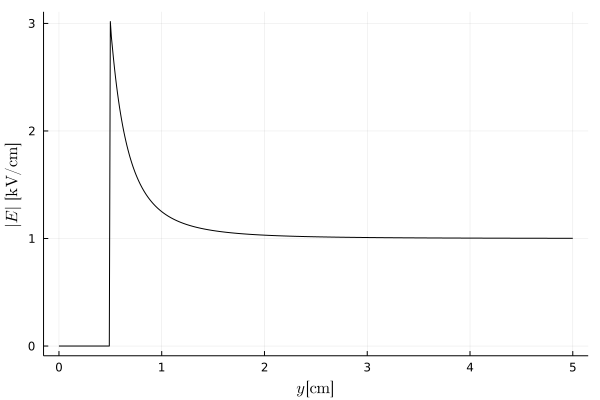

In [46]:
plot(y * 1e2, Eline * 1e-5, color = :black, legend = :false, xlabel = L"y\,\mathrm{[cm]}", ylabel = L"|E|\,\mathrm{[kV/cm]}")

In [47]:
f = maximum(Eline) / E0

3.0174244744419556

As expected, the field enhancement factor $f \approx 3$

## Along $x$ axis

In [48]:
x = Vector(0:1e-4:5*r)
coord = [Point(x[i], 0) for i in 1:length(x)];
uline = uh(coord);
Eline = E(coord);
Eline = [sqrt(E[1]^2 + E[2]^2)  for E in Eline];

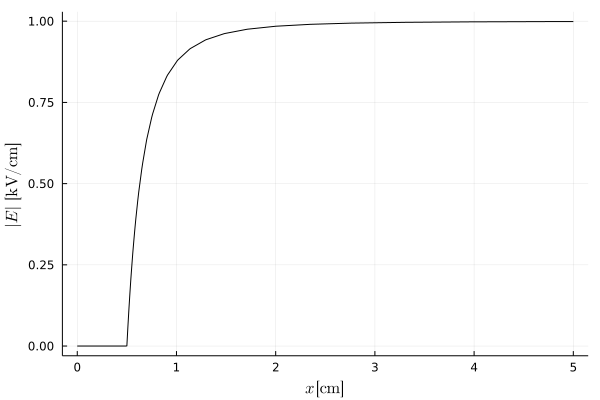

In [49]:
plot(x * 1e2, Eline * 1e-5, color = :black, legend = :false, xlabel = L"x\,\mathrm{[cm]}", ylabel = L"|E|\,\mathrm{[kV/cm]}")

In the corners, the field becomes zero

# Export to VTK

In [50]:
writevtk(Ω,"enh_hemisphere", cellfields=["uh" => uh, "E" => E])

(["enh_hemisphere.vtu"],)